In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/LSWMD.pkl')

In [5]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [6]:
df = df.astype({"trianTestLabel": str, "failureType":str})

In [7]:
df["failureType"].unique()

array(["[['none']]", "[['Loc']]", '[]', "[['Edge-Loc']]", "[['Center']]",
       "[['Edge-Ring']]", "[['Scratch']]", "[['Random']]",
       "[['Near-full']]", "[['Donut']]"], dtype=object)

In [8]:
index_names = df[(df["failureType"] == "[['none']]") | (df["failureType"] == "[]")].index
df = df.drop(index_names)

In [9]:
df = df.reset_index(drop = True)

In [10]:
df["failureType"].unique()

array(["[['Loc']]", "[['Edge-Loc']]", "[['Center']]", "[['Edge-Ring']]",
       "[['Scratch']]", "[['Random']]", "[['Near-full']]", "[['Donut']]"],
      dtype=object)

In [11]:
wafer_map = list(df["waferMap"])

(array([2.3188e+04, 1.9506e+04, 6.2050e+03, 5.6100e+02, 7.6200e+02,
        1.9000e+02, 5.9100e+02, 2.2000e+01, 2.0000e+00, 1.1000e+01]),
 array([ 18. ,  37.4,  56.8,  76.2,  95.6, 115. , 134.4, 153.8, 173.2,
        192.6, 212. ]),
 <BarContainer object of 10 artists>)

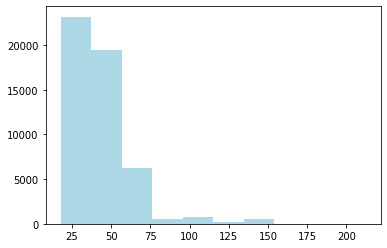

In [ ]:
# # check shape distribute
# shapes = []
# for wafer in wafer_map:
#     shapes.append(wafer.shape[0])
#     shapes.append(wafer.shape[1])
# plt.hist(shapes, density=False, color = 'lightblue', cumulative = False, label = "shapes")

In [12]:
width = 25
height = 25
x = []
y = []
for i in range(len(wafer_map)):
    resized = cv2.resize(wafer_map[i], (width, height), interpolation = cv2.INTER_AREA)
    resized = resized.reshape((resized.shape[0], resized.shape[1], 1))
#     # if you want to use transfer learning
#     gray_three_channel = cv2.cvtColor(resized, cv2.COLOR_GRAY2BGR)
    x.append(resized)
    y.append(df.loc[i, "failureType"])
x = np.array(x)
print(x.shape)

(25519, 25, 25, 1)


In [22]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
import seaborn
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
classes_num = len(le.classes_)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify = y, shuffle = True)
print(x_train.shape)
print(x_test.shape)

(20415, 25, 25, 1)
(5104, 25, 25, 1)


In [16]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify = y_train, shuffle = True)
print(x_train.shape)
print(x_val.shape)

(16332, 25, 25, 1)
(4083, 25, 25, 1)


In [17]:
epochs = 100
batch_size = 64

In [ ]:
# # transfer learning
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape = (width, height, 3))
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# predictions = Dense(classes_num, activation='softmax')(x)

# model = Model(base_model.input, predictions)
# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# model.summary()
# hist = model.fit(x_train, y_train, batch_size = batch_size, epochs=epochs, validation_split = 0.2, shuffle = True)

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())
model.add(layers.Dense(classes_num, activation='softmax'))
model.summary()
model.compile(optimizer="nadam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 23, 23, 32)        320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 23, 23, 32)        128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 21, 21, 64)        256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 19, 19, 128)      

In [23]:
cb = [EarlyStopping(patience=10)]

In [24]:
hist = model.fit(x_train, y_train, batch_size = batch_size, epochs=epochs, validation_data = (x_val, y_val), callbacks=cb,shuffle = True)

Epoch 1/100
256/256 [==============================] - 112s 439ms/step - loss: 1.0378 - accuracy: 0.6306 - val_loss: 5.2975 - val_accuracy: 0.3799
Epoch 2/100
256/256 [==============================] - 112s 437ms/step - loss: 0.7379 - accuracy: 0.7238 - val_loss: 1.3442 - val_accuracy: 0.4847
Epoch 3/100
256/256 [==============================] - 113s 440ms/step - loss: 0.6430 - accuracy: 0.7551 - val_loss: 1.0335 - val_accuracy: 0.6231
Epoch 4/100
256/256 [==============================] - 112s 437ms/step - loss: 0.5808 - accuracy: 0.7802 - val_loss: 0.6633 - val_accuracy: 0.7389
Epoch 5/100
256/256 [==============================] - 112s 436ms/step - loss: 0.5349 - accuracy: 0.7970 - val_loss: 2.9979 - val_accuracy: 0.4051
Epoch 6/100
256/256 [==============================] - 112s 437ms/step - loss: 0.5106 - accuracy: 0.8085 - val_loss: 0.5361 - val_accuracy: 0.7933
Epoch 7/100
256/256 [==============================] - 112s 436ms/step - loss: 0.4794 - accuracy: 0.8202 - val_loss: 0

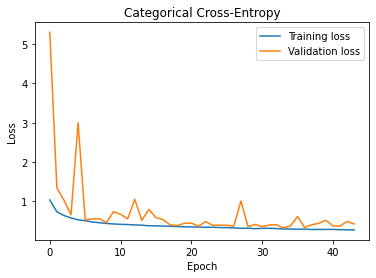

In [27]:
plt.figure()
plt.plot(hist .history['loss'], label='Training loss')
plt.plot(hist .history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Categorical Cross-Entropy')
plt.show()

In [31]:
hist.history

{'accuracy': [0.6306024789810181,
  0.7237938046455383,
  0.7551432847976685,
  0.780186116695404,
  0.7970242500305176,
  0.8085353970527649,
  0.82023024559021,
  0.8249449133872986,
  0.8327210545539856,
  0.838047981262207,
  0.8401910066604614,
  0.8439872860908508,
  0.8477222919464111,
  0.8489468693733215,
  0.8548861145973206,
  0.855437159538269,
  0.8580088019371033,
  0.8611315488815308,
  0.8603355288505554,
  0.8643154501914978,
  0.8682953715324402,
  0.86872398853302,
  0.8690301179885864,
  0.8681116700172424,
  0.8720915913581848,
  0.8719691634178162,
  0.8776022791862488,
  0.8791329860687256,
  0.8785819411277771,
  0.8854396343231201,
  0.8817658424377441,
  0.8810923099517822,
  0.8820107579231262,
  0.8878887891769409,
  0.8864805102348328,
  0.8880724906921387,
  0.8898481726646423,
  0.8905829191207886,
  0.8905829191207886,
  0.8887460231781006,
  0.889970600605011,
  0.8948689699172974,
  0.8953588008880615,
  0.8951138854026794],
 'loss': [1.037842988967895

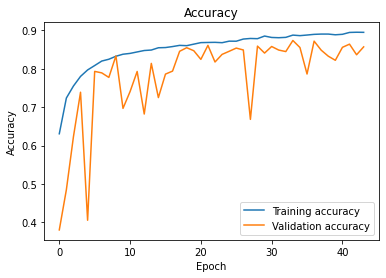

In [32]:
plt.figure()
plt.plot(hist.history['accuracy'], label='Training accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [25]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"accuracy: {accuracy}")

160/160 [==============================] - 8s 49ms/step - loss: 0.4656 - accuracy: 0.8495
accuracy: 0.8495298027992249


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


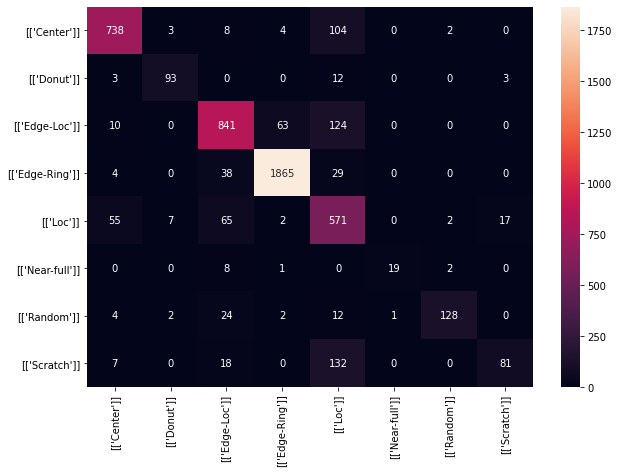

In [33]:
array = confusion_matrix(y_test, model.predict_classes(x_test))
df_cm = pd.DataFrame(array, index = [i for i in le.classes_], columns = [i for i in le.classes_])
df_norm_col=(df-df.mean())/df.std()

plt.figure(figsize = (10,7))
seaborn.heatmap(df_cm, annot=True, fmt="d")